## Imports and constants

In [ ]:
#!g1.1
# %pip install torchsummary pytorch-lightning albumentations==1.2.1 numpy~=1.19.2 pandas~=1.1.0 seaborn
%pip install torchsummary pytorch-lightning albumentations==1.2.1 # numpy~=1.19.2 pandas~=1.1.0 seaborn

In [ ]:
#!g1.1
%pip install git+https://github.com/KhrulkovV/tt-pytorch.git

In [217]:
#!g1.1
from functools import lru_cache
import gc
import os
import time
import glob
import copy
import json
import random
import shutil
import requests
import subprocess
from urllib.request import urlretrieve
from typing import Any, Callable, Dict, Iterable, List, Tuple
from collections import defaultdict, OrderedDict

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")

from joblib import load, dump

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Библиотеки для обучения
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.utils.random import sample_without_replacement

from torchsummary import summary

# Библиотеки для обработки изображений
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import scipy.io

# Библиотеки для визуализации
import ipywidgets as widgets
from IPython.display import clear_output
from IPython import display

In [218]:
#!g1.1
INPUT_SIZE = 320

PREFERABLE_BATCH_SIZE = 32
BATCH_SIZE = 32
ACCUM_GRAD = (PREFERABLE_BATCH_SIZE - 1) // BATCH_SIZE + 1

CLASS_INFO = {
    "people": {
        "filename": "cocostuff_people_1_3.5k_0.1.csv",
        "idx": 1,
    },
    "tree": {
        "filename": "cocostuff_tree_169_2.5k_0.2.csv",
        "idx": 169,
    },
}

CHOSEN_CLASS = "tree"
CLASS_IDX = CLASS_INFO[CHOSEN_CLASS]["idx"]
SPLIT_FILENAME = CLASS_INFO[CHOSEN_CLASS]["filename"]

## Data

### Dataset Loading: Cocostuff

In [ ]:
#!g1.1
!rm -rf ./datasets
!mkdir ./datasets

!rm -rf ./checkpoints
!mkdir ./checkpoints

In [ ]:
#!g1.1
!wget -q http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.zip
!unzip -qn cocostuff-10k-v1.1.zip -d ./datasets/COCOSTUFF
!rm -rf cocostuff-10k-v1.1.zip

### Visualization

In [219]:
#!g1.1
gt_path = "./datasets/COCOSTUFF/annotations"
image_path = "./datasets/COCOSTUFF/images"
gt_filenames = sorted(os.listdir(gt_path))
images_filenames = sorted(os.listdir(image_path))
len(gt_filenames), gt_filenames[:10], len(images_filenames), images_filenames[:10]

(10000,
 ['COCO_train2014_000000000077.mat',
  'COCO_train2014_000000000113.mat',
  'COCO_train2014_000000000127.mat',
  'COCO_train2014_000000000260.mat',
  'COCO_train2014_000000000349.mat',
  'COCO_train2014_000000000368.mat',
  'COCO_train2014_000000000389.mat',
  'COCO_train2014_000000000431.mat',
  'COCO_train2014_000000000446.mat',
  'COCO_train2014_000000000575.mat'],
 10000,
 ['COCO_train2014_000000000077.jpg',
  'COCO_train2014_000000000113.jpg',
  'COCO_train2014_000000000127.jpg',
  'COCO_train2014_000000000260.jpg',
  'COCO_train2014_000000000349.jpg',
  'COCO_train2014_000000000368.jpg',
  'COCO_train2014_000000000389.jpg',
  'COCO_train2014_000000000431.jpg',
  'COCO_train2014_000000000446.jpg',
  'COCO_train2014_000000000575.jpg'])

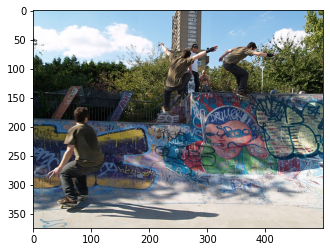

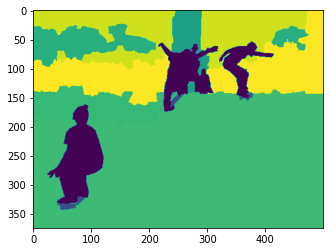

In [220]:
#!g1.1
sample_image = os.path.join(image_path, images_filenames[0])
sample_image = cv2.cvtColor(cv2.imread(sample_image), cv2.COLOR_BGR2RGB)

sample_mask = os.path.join(gt_path, images_filenames[0].replace(".jpg", ".mat",))
sample_mask = scipy.io.loadmat(sample_mask)['S']

plt.imshow(sample_image)
plt.show()
plt.imshow(sample_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 320, 320])
torch.Size([320, 320])


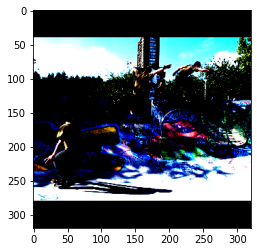

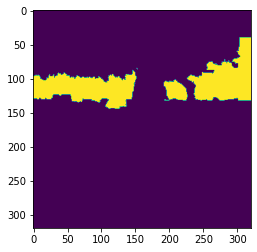

In [221]:
#!g1.1
def prepare_class_extractor(cls=1):
    def class_extractor(mask, **kwargs):
        return (mask == cls).astype(int)

    return class_extractor

coco_transform = A.Compose([
    A.Lambda(mask=prepare_class_extractor(cls=CLASS_IDX)),
    A.LongestMaxSize(INPUT_SIZE, cv2.INTER_LINEAR),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.PadIfNeeded(INPUT_SIZE, INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0),
    ToTensorV2(),
])

transformed = coco_transform(image=sample_image, mask=sample_mask)
transformed_image = transformed["image"]
transformed_mask = transformed["mask"]

print(transformed_image.shape)
print(transformed_mask.shape)
plt.imshow(torch.permute(transformed_image, (1, 2, 0)))
plt.show()
plt.imshow(transformed_mask)

In [222]:
#!g1.1
class CocoStuffDataset(Dataset):
    def __init__(self, image_path, mask_path, filenames, transform=None, preprocess=False):
        """
        Args:
            image_path: путь до изображений
            mask_path: путь до масок
            filenames: список изображений
            transform: трансформация для изображений.
        """
        self.image_path = image_path
        self.mask_path = mask_path
        self.filenames = filenames
        self.transform = transform
        self.preprocess = preprocess

        if preprocess:
            self.preprocessed = []
            for filename in tqdm(filenames):
                self.preprocessed.append(
                    self.transform(
                        image=cv2.cvtColor(
                            cv2.imread(os.path.join(self.image_path, filename + ".jpg")),
                            cv2.COLOR_BGR2RGB,
                        ),
                        mask=scipy.io.loadmat(
                            os.path.join(self.mask_path, filename + ".mat"),
                        )['S'],
                    )
                )

    def __len__(self):
        return len(self.filenames)

    def get_preprocessed_image(self, idx):
        return self.preprocessed[idx]

    def get_processed_image(self, idx):
        return self.transform(
            image=cv2.cvtColor(
                cv2.imread(os.path.join(self.image_path, self.filenames[idx] + ".jpg")),
                cv2.COLOR_BGR2RGB,
            ),
            mask=scipy.io.loadmat(
                os.path.join(self.mask_path, self.filenames[idx] + ".mat"),
            )['S'],
        )

    def __getitem__(self, idx):
        if self.preprocess:
            return self.get_preprocessed_image(idx)
        return self.get_processed_image(idx)

In [223]:
#!g1.1
def setup_dataloaders(dataset_split, k=8, gt_path=gt_path, image_path=image_path,
                      batch_size=BATCH_SIZE, transform=coco_transform, preprocess=False):
    train = dataset_split[(dataset_split['split'] == "train") & (dataset_split['group'] < k)].filenames.tolist()
    valid = dataset_split[(dataset_split['split'] == "valid") & (dataset_split['group'] < k)].filenames.tolist()
    test = dataset_split[(dataset_split['split'] == "test") & (dataset_split['group'] < k)].filenames.tolist()

    train_dataset = CocoStuffDataset(
        image_path,
        gt_path,
        train,
        transform=transform,
        preprocess=preprocess,
    )

    train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=batch_size,
        num_workers=2,
    )


    valid_dataset = CocoStuffDataset(
        image_path,
        gt_path,
        valid,
        transform=transform,
        preprocess=preprocess,
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        shuffle=False,
        batch_size=batch_size,
        num_workers=2,
    )


    test_dataset = CocoStuffDataset(
        image_path,
        gt_path,
        test,
        transform=transform,
        preprocess=preprocess,
    )

    test_dataloader = DataLoader(
        test_dataset,
        shuffle=False,
        batch_size=batch_size,
        num_workers=2,
    )

    return {
        "train": train_dataloader,
        "valid": valid_dataloader,
        "test": test_dataloader,
    }

## Model, loss and training functions

### U-Net

#### Blocks

In [224]:
#!g1.1
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False, upsample_mode='bilinear'):
        super().__init__()
        if upsample:
            self.up = nn.Sequential([
                nn.Upsample(scale_factor=2, mode=upsample_mode),
                nn.Conv2d(in_channels, in_channels // 2, 1, bias=False)
            ])
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, out_channels)

    def forward(self, prev, skip):
        return self.conv(
            torch.cat([self.up(prev), skip], dim=-3)
        )

#### U-Net Model

In [225]:
#!g1.1
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, depth=3, start_channels=32,
                 upsample=False, upsample_mode='bilinear'):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.depth = depth
        self.multiple = 2 ** depth
        self.start_channels = start_channels
        self.threshold = 0.5

        self.upsample = upsample
        if upsample:
            self.upsample_mode = upsample_mode

        self.downs = [DoubleConv(n_channels, start_channels)]
        channels = (start_channels, start_channels * 2)
        for k in range(depth - 1):
            self.downs.append(DownBlock(*channels))
            channels = (channels[1], channels[1] * 2)

        self.downs = nn.ModuleList(self.downs)
        self.center = DownBlock(*channels)

        channels = (channels[1], channels[1] // 2)
        self.ups = []
        for k in range(depth):
            self.ups.append(UpBlock(*channels))
            channels = (channels[1], channels[1] // 2)
        self.ups = nn.ModuleList(self.ups)

        self.out = nn.Conv2d(channels[0], n_classes, 1)

    def set_threshold(self, ths):
        self.threshold = ths

    def forward(self, x):
        H, W = x.shape[-2:]
        if H % self.multiple != 0 or W % self.multiple != 0:
            new_H = ((H - 1) // self.multiple + 1) * self.multiple
            new_W = ((W - 1) // self.multiple + 1) * self.multiple
            x = F.pad(x, [0, new_W - W, 0, new_H - H])

        skips = []
        out = x
        for d_block in self.downs:
            out = d_block(out)
            skips.append(out)
        out = self.center(out)

        for skip, u_block in zip(skips[::-1], self.ups):
            out = u_block(out, skip)

        out = self.out(out)
        if H % self.multiple != 0 or W % self.multiple != 0:
            out = out[:, :, :H, :W]

        return out

    def predict(self, x):
        logits = self.forward(x)
        if self.n_classes != 1:
            return logits.argmax(dim=-3)
        return (F.sigmoid(logits) >= self.threshold).to(int)

    def prepare_for_train(self):
        self.train()

    def prepare_for_eval(self):
        self.eval()

### MARS import

In [226]:
#!g1.1
from mars import MARS, MARSLoss, get_MARS_attr, set_MARS_attr
from tensorized_models import TTLinear, TTConv2d, TuckerConv2d, FactorizedLinear

modes_dict = {
    "soft": dict(pi=1e-1, alpha=-1.5),
    "hard": dict(pi=1e-2, alpha=-1.75),
}

In [227]:
#!g1.1
def prepare_for_validation(model):
    if isinstance(model, MARS):
        model.warmup = True

def prepare_for_train(model):
    if isinstance(model, MARS):
        model.warmup = False

### Tucker U-Net

In [228]:
#!g1.1
def get_tucker_conv2d(in_channels, out_channels, kernel_size=3, padding=1, rank=30, pi=1e-1, alpha=-1.5):
    return MARS(
        TuckerConv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, rank=rank),
        pi=pi,
        alpha=alpha,
    )

class TuckerDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, rank=20, pi=1e-1, alpha=-1.5, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.conv = nn.Sequential(
            get_tucker_conv2d(in_channels, mid_channels, 3, 1, rank, pi, alpha),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            get_tucker_conv2d(mid_channels, out_channels, 3, 1, rank, pi, alpha),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)


class TuckerDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, rank=20, pi=1e-1, alpha=-1.5, ):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            TuckerDoubleConv(in_channels, out_channels, rank=rank, pi=pi, alpha=alpha),
        )

    def forward(self, x):
        return self.block(x)


class TuckerUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False, upsample_mode='bilinear',
                 rank=20, pi=1e-1, alpha=-1.5, ):
        super().__init__()
        if upsample:
            self.up = nn.Sequential([
                nn.Upsample(scale_factor=2, mode=upsample_mode),
                get_tucker_conv2d(in_channels, in_channels // 2, 1, 0, rank, pi, alpha),
            ])
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = TuckerDoubleConv(in_channels, out_channels, rank=rank, pi=pi, alpha=alpha)

    def forward(self, prev, skip):
        return self.conv(
            torch.cat([self.up(prev), skip], dim=-3)
        )


class TuckerUNet(nn.Module):
    def __init__(self, n_channels, n_classes, depth=3, start_channels=32,
                 upsample=False, upsample_mode='bilinear',
                 rank=20, encoder_only=False, pi=1e-1, alpha=-1.5,):
        super(TuckerUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.depth = depth
        self.multiple = 2 ** depth
        self.start_channels = start_channels
        self.threshold = 0.5

        self.upsample = upsample
        if upsample:
            self.upsample_mode = upsample_mode

        self.downs = [TuckerDoubleConv(n_channels, start_channels, rank=rank, pi=pi, alpha=alpha)]
        channels = (start_channels, start_channels * 2)
        for k in range(depth - 1):
            self.downs.append(TuckerDownBlock(*channels, rank=rank, pi=pi, alpha=alpha))
            channels = (channels[1], channels[1] * 2)

        self.downs = nn.ModuleList(self.downs)
        self.center = TuckerDownBlock(*channels, rank=rank, pi=pi, alpha=alpha)

        channels = (channels[1], channels[1] // 2)
        self.ups = []
        for k in range(depth):
            if encoder_only:
                self.ups.append(UpBlock(*channels))
            else:
                self.ups.append(TuckerUpBlock(*channels, rank=rank, pi=pi, alpha=alpha))
            channels = (channels[1], channels[1] // 2)
        self.ups = nn.ModuleList(self.ups)

        if encoder_only:
            self.out = nn.Conv2d(channels[0], n_classes, kernel_size=1, padding=0,)
        else:
            self.out = get_tucker_conv2d(channels[0], n_classes, 1, 0, rank, pi, alpha)

    def set_threshold(self, ths):
        self.threshold = ths

    def forward(self, x):
        H, W = x.shape[-2:]
        if H % self.multiple != 0 or W % self.multiple != 0:
            new_H = ((H - 1) // self.multiple + 1) * self.multiple
            new_W = ((W - 1) // self.multiple + 1) * self.multiple
            x = F.pad(x, [0, new_W - W, 0, new_H - H])

        skips = []
        out = x
        for d_block in self.downs:
            out = d_block(out)
            skips.append(out)
        out = self.center(out)

        for skip, u_block in zip(skips[::-1], self.ups):
            out = u_block(out, skip)

        out = self.out(out)
        if H % self.multiple != 0 or W % self.multiple != 0:
            out = out[:, :, :H, :W]

        return out

    def predict(self, x):
        logits = self.forward(x)
        if self.n_classes != 1:
            return logits.argmax(dim=-3)
        return (F.sigmoid(logits) >= self.threshold).to(int)

    def prepare_for_train(self):
        self.train()
        self.apply(prepare_for_train)

    def prepare_for_eval(self):
        self.eval()
        self.apply(prepare_for_validation)

### TT U-Net

In [229]:
#!g1.1
def get_tt_conv2d(in_channels, out_channels, kernel_size=3, padding=1, d=6, tt_rank=8, pi=1e-1, alpha=-1.5):
    return MARS(
        TTConv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False, d=d, tt_rank=tt_rank, ),
        pi=pi,
        alpha=alpha,
    )

class TTDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, d=6, tt_rank=8, pi=1e-1, alpha=-1.5, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.conv = nn.Sequential(
            get_tt_conv2d(in_channels, mid_channels, 3, 1, d, tt_rank, pi, alpha),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            get_tt_conv2d(mid_channels, out_channels, 3, 1, d, tt_rank, pi, alpha),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)


class TTDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, d=6, tt_rank=8, pi=1e-1, alpha=-1.5, ):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            TTDoubleConv(in_channels, out_channels, d=d, tt_rank=tt_rank, pi=pi, alpha=alpha),
        )

    def forward(self, x):
        return self.block(x)


class TTUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False, upsample_mode='bilinear',
                 d=6, tt_rank=8, pi=1e-1, alpha=-1.5, ):
        super().__init__()
        if upsample:
            self.up = nn.Sequential([
                nn.Upsample(scale_factor=2, mode=upsample_mode),
                get_tt_conv2d(in_channels, in_channels // 2, 1, 0, d, tt_rank, pi, alpha),
            ])
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = TTDoubleConv(in_channels, out_channels, d=d, tt_rank=tt_rank, pi=pi, alpha=alpha)

    def forward(self, prev, skip):
        return self.conv(
            torch.cat([self.up(prev), skip], dim=-3)
        )


class TTUNet(nn.Module):
    def __init__(self, n_channels, n_classes, depth=3, start_channels=32,
                 upsample=False, upsample_mode='bilinear',
                 d=6, tt_rank=8, encoder_only=False, pi=1e-1, alpha=-1.5,):
        super(TTUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.depth = depth
        self.multiple = 2 ** depth
        self.start_channels = start_channels
        self.threshold = 0.5

        self.upsample = upsample
        if upsample:
            self.upsample_mode = upsample_mode

        self.downs = [TTDoubleConv(n_channels, start_channels, d=d, tt_rank=tt_rank, pi=pi, alpha=alpha)]
        channels = (start_channels, start_channels * 2)
        for k in range(depth - 1):
            self.downs.append(TTDownBlock(*channels, d=d, tt_rank=tt_rank, pi=pi, alpha=alpha))
            channels = (channels[1], channels[1] * 2)

        self.downs = nn.ModuleList(self.downs)
        self.center = TTDownBlock(*channels, d=d, tt_rank=tt_rank, pi=pi, alpha=alpha)

        channels = (channels[1], channels[1] // 2)
        self.ups = []
        for k in range(depth):
            if encoder_only:
                self.ups.append(UpBlock(*channels))
            else:
                self.ups.append(TTUpBlock(*channels, d=d, tt_rank=tt_rank, pi=pi, alpha=alpha))
            channels = (channels[1], channels[1] // 2)
        self.ups = nn.ModuleList(self.ups)

        if encoder_only:
            self.out = nn.Conv2d(channels[0], n_classes, kernel_size=1, padding=0,)
        else:
            self.out = get_tt_conv2d(channels[0], n_classes, 1, 0, d, tt_rank, pi, alpha)

    def set_threshold(self, ths):
        self.threshold = ths

    def forward(self, x):
        H, W = x.shape[-2:]
        if H % self.multiple != 0 or W % self.multiple != 0:
            new_H = ((H - 1) // self.multiple + 1) * self.multiple
            new_W = ((W - 1) // self.multiple + 1) * self.multiple
            x = F.pad(x, [0, new_W - W, 0, new_H - H])

        skips = []
        out = x
        for d_block in self.downs:
            out = d_block(out)
            skips.append(out)
        out = self.center(out)

        for skip, u_block in zip(skips[::-1], self.ups):
            out = u_block(out, skip)

        out = self.out(out)
        if H % self.multiple != 0 or W % self.multiple != 0:
            out = out[:, :, :H, :W]

        return out

    def predict(self, x):
        logits = self.forward(x)
        if self.n_classes != 1:
            return logits.argmax(dim=-3)
        return (F.sigmoid(logits) >= self.threshold).to(int)

    def prepare_for_train(self):
        self.train()
        self.apply(prepare_for_train)

    def prepare_for_eval(self):
        self.eval()
        self.apply(prepare_for_validation)

### Model analysis

In [230]:
#!g1.1
def get_comp_info(model):
    "Plot model masks probabilities, print compression info and return total compression."
    MARS_layers = [l for l in model.modules() if isinstance(l, MARS)]

    ranks_list = []
    totals, dofs = [], []

    for l in MARS_layers:
        print("Layer: ", l.tensorized_model)
        phi_logits_list = l.phi_logits_list
        F = l.F
        eval_logits_threshold = l.eval_logits_threshold
        p_threshold = F(torch.tensor(eval_logits_threshold)).item()
        ranks = []

        for m, logits in enumerate(phi_logits_list, 1):
            logits = logits.detach().cpu()
            probs = F(logits).data.numpy()

            plt.title(f"Mask {m}")
            plt.bar(np.arange(1, len(probs) + 1), probs)
            plt.xlabel('Rank')
            plt.ylabel(r'$\phi$ value')
            plt.hlines(p_threshold, 0, len(probs) + 1, linestyles='--')
            plt.text(0, p_threshold * 1.05, 'Rounding threshold')
            plt.show()

            rank = (logits > eval_logits_threshold).sum().item()
            print("#nz ranks: {0}/{1}".format(rank, len(logits)))
            ranks.append(rank)

        ranks_list.append(ranks)
        print()

        dofs.append(l.tensorized_model.calc_dof(ranks))
        totals.append(l.tensorized_model.total)
        comp = totals[-1] / dofs[-1]

        print("Compression:\t%.3f" % comp)
        print(100*"=")

    all_params = sum(p.numel() for p in model.parameters())
    mars_params = sum(logits.numel() for l in MARS_layers for logits in l.phi_logits_list)
    mars_params += sum(l.tensorized_model.calc_dof() for l in MARS_layers)
    other_params = all_params - mars_params

    total_comp = (other_params + sum(totals)) / (other_params + sum(dofs))
    print("Total compression:\t%.3f" % total_comp)

    return total_comp

In [231]:
#!g1.1
def get_init_comp_info(model):
    MARS_layers = [l for l in model.modules() if isinstance(l, MARS)]

    ranks_list = []
    totals, dofs = [], []

    for l in MARS_layers:
        ranks = l.tensorized_model._ranks

        dofs.append(l.tensorized_model.calc_dof(ranks))
        totals.append(l.tensorized_model.total)
        comp = totals[-1] / dofs[-1]

    all_params = sum(p.numel() for p in model.parameters())
    mars_params = sum(logits.numel() for l in MARS_layers for logits in l.phi_logits_list)
    mars_params += sum(l.tensorized_model.calc_dof() for l in MARS_layers)
    other_params = all_params - mars_params

    total_comp = (other_params + sum(totals)) / (other_params + sum(dofs))
    print("Total compression:\t%.3f" % total_comp)

    return total_comp

### Check

In [232]:
#!g1.1
model = TTUNet(
    n_channels=3, n_classes=2, depth=3, start_channels=32,
    d = 3, tt_rank = 22, pi = 1e-1, alpha = -1.5, encoder_only=True,
)
get_init_comp_info(model)

Total compression:	2.033


2.033160794508581

In [233]:
#!g1.1
model = TuckerUNet(
    n_channels=3, n_classes=2, depth=3, start_channels=32,
    rank = 40, pi = 1e-1, alpha = -1.5, encoder_only=True,
)
get_init_comp_info(model)

Total compression:	2.054


2.0541559324345346

In [234]:
#!g1.1
model = TTUNet(
    n_channels=3, n_classes=2, depth=3, start_channels=32,
    d = 3, tt_rank = 35, pi = 1e-1, alpha = -1.5, encoder_only=False,
)
get_init_comp_info(model)

Total compression:	2.018


2.0181134225320254

In [235]:
#!g1.1
model = TuckerUNet(
    n_channels=3, n_classes=2, depth=3, start_channels=32,
    rank = 68, pi = 1e-1, alpha = -1.5, encoder_only=False,
)
get_init_comp_info(model)

Total compression:	2.018


2.0181401861530124

In [236]:
#!g1.1
model.cuda()
model.prepare_for_eval()
model.eval()
model(torch.randn(13, 3, 320, 320).cuda()).shape

torch.Size([13, 2, 320, 320])

### Loss

In [237]:
#!g1.1
def dice_loss(target, logits, smooth=1e-6):
    probs = None
    if len(logits.shape) == 4 and logits.shape[-3] != 1:
        probs = F.softmax(logits, dim=-3)
    else:
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probs = torch.cat([neg_prob, pos_prob], dim=-3)

    target_onehot = torch.eye(2).type(logits.type())[target.long().squeeze(1)].permute(0, 3, 1, 2)

    dims = (0,) + tuple(range(2, target.ndimension()))
    numer = (probs * target_onehot).sum(dim=dims)
    denom = (probs + target_onehot).sum(dim=dims)
    dice_score = (2. * numer / (denom + smooth)).mean()
    return (1 - dice_score)

def bce_loss(target, logits, weight=torch.tensor([.5, .5])):
    p_t = None
    if len(logits.shape) == 4 and logits.shape[-3] != 1:
        probs = F.softmax(logits, dim=-3)
        p_t = torch.where(target.to(bool), probs[:, 1], probs[:, 0])
    else:
        probs = F.sigmoid(logits)
        p_t = torch.where(target.to(bool), probs, 1 - probs)

    weight_t = weight.type(logits.type())[target.long()]
    return -(weight_t * torch.log(p_t)).mean()

In [238]:
#!g1.1
target = torch.randint(0, 2, (8, 1, 127, 127))
logits = torch.randn(8, 1, 127, 127)

(
    dice_loss(target, logits),
    bce_loss(target, logits),
)

(tensor(0.4995), tensor(0.4024))

In [239]:
#!g1.1
all_loss_params = {
    "dice_loss": {"func": dice_loss, "loss_params": {},},
    "bce_loss": {"func": bce_loss, "loss_params": {},},
}

### Metrics

In [240]:
#!g1.1
def dice_metric(target, preds, threshold=None, reduce=False):
    assert target.shape == preds.shape
    if torch.is_tensor(target):
        target = target.detach().cpu().numpy()
    if torch.is_tensor(preds):
        preds = preds.detach().cpu().numpy()

    if threshold is not None:
        preds = (preds >= threshold).astype(int)

    numer = (preds * target).mean(axis=(-1, -2))
    denom = preds.mean(axis=(-1, -2)) + target.mean(axis=(-1, -2))
    dice = np.where(denom == 0, 0, 2 * numer / denom)

    if reduce:
        return dice.mean()
    return dice.squeeze()


def iou_metric(target, preds, threshold=None, reduce=False):
    assert target.shape == preds.shape
    if torch.is_tensor(target):
        target = target.detach().cpu().numpy()
    if torch.is_tensor(preds):
        preds = preds.detach().cpu().numpy()

    if threshold is not None:
        preds = (preds >= threshold).astype(int)

    numer = (preds * target).mean(axis=(-1, -2))
    denom = preds.mean(axis=(-1, -2)) + target.mean(axis=(-1, -2)) - numer
    iou = np.where(denom == 0, 1, numer / denom)

    if reduce:
        return iou.mean()
    return iou.squeeze()


def recall_metric(target, preds, threshold=None, reduce=False):
    assert target.shape == preds.shape
    if torch.is_tensor(target):
        target = target.detach().cpu().numpy()
    if torch.is_tensor(preds):
        preds = preds.detach().cpu().numpy()

    if threshold is not None:
        preds = (preds >= threshold).astype(int)

    numer = (preds * target).mean(axis=(-1, -2))
    denom = target.mean(axis=(-1, -2))
    recall = np.where(denom == 0, 1, numer / denom)

    if reduce:
        return recall.mean()
    return recall.squeeze()


def precision_metric(target, preds, threshold=None, reduce=False):
    assert target.shape == preds.shape
    if torch.is_tensor(target):
        target = target.detach().cpu().numpy()
    if torch.is_tensor(preds):
        preds = preds.detach().cpu().numpy()

    if threshold is not None:
        preds = (preds >= threshold).astype(int)

    numer = (preds * target).mean(axis=(-1, -2))
    denom = preds.mean(axis=(-1, -2))
    precision = np.where(denom == 0, 1, numer / denom)

    if reduce:
        return precision.mean()
    return precision.squeeze()

In [241]:
#!g1.1
target = torch.randint(0, 2, (8, 1, 127, 127))
logits = torch.randn(8, 1, 127, 127)
preds = (logits > 0).to(int)

(
    dice_metric(target, preds, reduce=True),
    iou_metric(target, preds, reduce=True),
    recall_metric(target, preds, reduce=True),
    precision_metric(target, preds, reduce=True),
)

(0.5019955112714555,
 0.33512444735071417,
 0.5035392866191546,
 0.5004769013522166)

In [242]:
#!g1.1
target = torch.randint(0, 2, (8, 127, 127))
logits = torch.randn(8, 127, 127)
preds = (logits > 0).to(int)

(
    dice_metric(target, preds, reduce=True),
    iou_metric(target, preds, reduce=True),
    recall_metric(target, preds, reduce=True),
    precision_metric(target, preds, reduce=True),
)

(0.4975374432828309, 0.331157910483778, 0.496824783584395, 0.49830634443038335)

In [243]:
#!g1.1
target = torch.randint(0, 2, (8, 1, 127, 127))
logits = torch.randn(8, 2, 127, 127)
preds = logits.argmax(dim=-3, keepdims=True)
print(preds.shape)

(
    dice_metric(target, preds, reduce=True),
    iou_metric(target, preds, reduce=True),
    recall_metric(target, preds, reduce=True),
    precision_metric(target, preds, reduce=True),
)

torch.Size([8, 1, 127, 127])


(0.500624695771457, 0.3339185308663064, 0.5000040460925093, 0.5012575814984426)

### Training Module

In [244]:
#!g1.1
class LightningSegmentation(pl.LightningModule):
    def __init__(self, model, loss_func=dice_loss, loss_params=dict(), dataloaders=dict(),
                 optim_cls=torch.optim.Adam, optim_params=dict(),
                 scheduler_cls=None, scheduler_params=dict(),
                 visualize_step=100, checkpointing=False, checkpoint_path=None,
                 compile=False, checkpoint_metric_name="valid_dice",
                 valid_eps_restart=0.01, valid_n_restart=5,):
        super().__init__()

        self.model = model
        self.dataloaders = dataloaders
        self.checkpointing = checkpointing
        self.checkpoint_path = checkpoint_path
        self.checkpoint_metric_name = checkpoint_metric_name
        self.compile = compile
        if compile:
            model = torch.compile(model)
            print('\t\t==============================================')
            print('\t\t============= Model compiled =================')
            print('\t\t==============================================')

        self.valid_eps_restart = valid_eps_restart
        self.valid_n_restart = valid_n_restart
        self.restart_flag = False

        self.optim_params = optim_params
        self.scheduler_params = scheduler_params
        self.optimizer = optim_cls(self.model.parameters(), **self.optim_params)
        self.scheduler = None
        if scheduler_cls is not None:
            self.scheduler = scheduler_cls(self.optimizer, **self.scheduler_params)

        self.loss_func = loss_func
        self.loss_params = loss_params

        assert (not checkpointing) or (checkpoint_path is not None)
        assert loss_func is not None

        self.info = defaultdict(list)
        self.visualize_step = visualize_step

        self.fig, self.ax = plt.subplots(1, 2, figsize=(12, 4))
        self.dh = display.display(self.fig, display_id=True)

    def clear_cache(self, k=3):
        for k in range(k):
            torch.cuda.empty_cache()
            gc.collect()

    def save_model(self):
        if os.path.exists(self.checkpoint_path):
            os.remove(self.checkpoint_path)

        if self.compile:
            torch.save(self.model._orig_mod.cpu().state_dict(), self.checkpoint_path)
        else:
            torch.save(self.model.cpu().state_dict(), self.checkpoint_path)
        self.model = self.model.cuda()
        print("\t\t======================= MODEL SAVED ==========================")

    def load_model(self, path=None):
        if path is None:
            path = self.checkpoint_path

        if self.compile and hasattr(self.model, "_orig_mod"):
            self.model = self.model._orig_mod

        self.model.load_state_dict(torch.load(path))
        self.model = self.model.cuda()

        if self.compile:
            self.model = torch.compile(self.model).cuda()
        print("\t\t======================= MODEL LOADED =========================")

    def check_metric_and_checkpoint(self):
        if len(self.info[self.checkpoint_metric_name]) <= 1:
            self.save_model()
            return

        best_metric = max(self.info[self.checkpoint_metric_name])
        if self.info[self.checkpoint_metric_name][-1] == best_metric:
            self.save_model()

    def configure_optimizers(self):
        if self.scheduler is not None:
            return {
                "optimizer": self.optimizer,
                "lr_scheduler": self.scheduler,
            }
        return self.optimizer

    def compute_loss(self, logits, labels):
        return self.loss_func(labels, logits, **self.loss_params)

    def restart_model_if_needed(self):
        if self.restart_flag:
            self.load_model()
            self.optimizer.__setstate__({'state': defaultdict(dict)})
            self.restart_flag = False

    def on_train_start(self):
        self.model.prepare_for_train()

    def training_step(self, batch, batch_idx):
        self.restart_model_if_needed()
        image = batch['image']
        labels = batch['mask']

        logits = self.model(image)
        loss = self.compute_loss(logits, labels)

        self.info['train_loss'].append(loss.detach().cpu().numpy().mean())
        self.log("train_loss", self.info['train_loss'][-1])

        if batch_idx % self.visualize_step == 0:
            self.ax[0].clear()
            self.ax[0].plot(self.info['train_loss'])
            self.dh.update(self.fig)

        if torch.all(torch.isnan(loss)).item():
            self.restart_flag = True

        return loss

    def on_train_epoch_end(self):
        self.ax[0].clear()
        self.ax[0].plot(self.info['train_loss'])
        self.dh.update(self.fig)

        self.clear_cache()
        self.restart_model_if_needed()

    def on_validation_start(self):
        self.model.prepare_for_eval()

    def validation_step(self, batch, _):
        image = batch['image']
        labels = batch['mask']

        with torch.no_grad():
            preds = self.model.predict(image)
            self.info['valid_preds'].append(preds.detach().cpu().numpy().squeeze())
            self.info['valid_labels'].append(labels.detach().cpu().numpy().squeeze())

    def on_validation_epoch_end(self):
        valid_preds = np.concatenate(self.info['valid_preds'])
        valid_labels = np.concatenate(self.info['valid_labels'])

        self.info['valid_preds'] = []
        self.info['valid_labels'] = []

        valid_dice = dice_metric(valid_labels, valid_preds, reduce=False)
        valid_iou = iou_metric(valid_labels, valid_preds, reduce=False)
        valid_recall = recall_metric(valid_labels, valid_preds, reduce=False)
        valid_precision = precision_metric(valid_labels, valid_preds, reduce=False)

        valid_dice_mean = valid_dice.mean()
        valid_iou_mean = valid_iou.mean()
        valid_recall_mean = valid_recall.mean()
        valid_precision_mean = valid_precision.mean()

        self.info['valid_dice'].append(valid_dice_mean)
        self.info['valid_iou'].append(valid_iou_mean)
        self.info['valid_recall'].append(valid_recall_mean)
        self.info['valid_precision'].append(valid_precision_mean)

        self.log("valid_dice", valid_dice_mean)

        self.ax[1].clear()
        self.ax[1].plot(self.info['valid_dice'], label='DICE')
        self.ax[1].plot(self.info['valid_iou'], label='IOU')
        self.ax[1].plot(self.info['valid_recall'], label='RECALL')
        self.ax[1].plot(self.info['valid_precision'], label='PRECISION')
        self.ax[1].legend()
        self.dh.update(self.fig)

        self.clear_cache()
        self.check_metric_and_checkpoint()

        if len(self.info['valid_recall']) >= self.valid_n_restart and \
           np.all(np.array(self.info['valid_recall'][-self.valid_n_restart:]) <= self.valid_eps_restart) and \
           np.all(np.array(self.info['valid_precision'][-self.valid_n_restart:]) >= 1. - self.valid_eps_restart):
            print("\t\t======================= OVERFITTING ==========================")
            self.restart_flag = True

        self.restart_model_if_needed()

    def on_test_start(self):
        self.model.prepare_for_eval()

    def test_step(self, batch, _):
        image = batch['image']
        labels = batch['mask']

        with torch.no_grad():
            preds = self.model.predict(image)
            self.info['test_preds'].append(preds.detach().cpu().numpy().squeeze())
            self.info['test_labels'].append(labels.detach().cpu().numpy().squeeze())

    def on_test_epoch_end(self):
        test_preds = np.concatenate(self.info['test_preds'])
        test_labels = np.concatenate(self.info['test_labels'])

        self.info['test_preds'] = []
        self.info['test_labels'] = []

        test_dice = dice_metric(test_labels, test_preds, reduce=False)
        test_iou = iou_metric(test_labels, test_preds, reduce=False)
        test_recall = recall_metric(test_labels, test_preds, reduce=False)
        test_precision = precision_metric(test_labels, test_preds, reduce=False)

        test_dice_mean = test_dice.mean()
        test_iou_mean = test_iou.mean()
        test_recall_mean = test_recall.mean()
        test_precision_mean = test_precision.mean()

        test_dice_var = test_dice.var(ddof=1)
        test_iou_var = test_iou.var(ddof=1)
        test_recall_var = test_recall.var(ddof=1)
        test_precision_var = test_precision.var(ddof=1)

        test_dice_q025 = np.quantile(test_dice, 0.025)
        test_iou_q025 = np.quantile(test_iou, 0.025)
        test_recall_q025 = np.quantile(test_recall, 0.025)
        test_precision_q025 = np.quantile(test_precision, 0.025)

        test_dice_q975 = np.quantile(test_dice, 0.975)
        test_iou_q975 = np.quantile(test_iou, 0.975)
        test_recall_q975 = np.quantile(test_recall, 0.975)
        test_precision_q975 = np.quantile(test_precision, 0.975)

        print()
        print("\t\t==============================================================")
        print("\tTEST DICE: mean = {:.4f}, std = {:.4f}, q2.5% = {:.4f}, q97.5% = {:.4f}".\
              format(test_dice_mean, test_dice_var, test_dice_q025, test_dice_q975))
        print("\tTEST IOU: mean = {:.4f}, std = {:.4f}, q2.5% = {:.4f}, q97.5% = {:.4f}".\
              format(test_iou_mean, test_iou_var, test_iou_q025, test_iou_q975))
        print("\tTEST RECALL: mean = {:.4f}, std = {:.4f}, q2.5% = {:.4f}, q97.5% = {:.4f}".\
              format(test_recall_mean, test_recall_var, test_recall_q025, test_recall_q975))
        print("\tTEST PRECISION: mean = {:.4f}, std = {:.4f}, q2.5% = {:.4f}, q97.5% = {:.4f}".\
              format(test_precision_mean, test_precision_var, test_precision_q025, test_precision_q975))
        print("\t\t==============================================================")
        print()

        self.log("test_dice_mean", test_dice_mean)
        self.log("test_dice_var", test_dice_var)
        self.log("test_dice_q025", test_dice_q025)
        self.log("test_dice_q975", test_dice_q975)

        self.log("test_iou_mean", test_iou_mean)
        self.log("test_iou_var", test_iou_var)
        self.log("test_iou_q025", test_iou_q025)
        self.log("test_iou_q975", test_iou_q975)

        self.log("test_recall_mean", test_recall_mean)
        self.log("test_recall_var", test_recall_var)
        self.log("test_recall_q025", test_recall_q025)
        self.log("test_recall_q975", test_recall_q975)

        self.log("test_precision_mean", test_precision_mean)
        self.log("test_precision_var", test_precision_var)
        self.log("test_precision_q025", test_precision_q025)
        self.log("test_precision_q975", test_precision_q975)

        self.clear_cache()

    def train_dataloader(self):
        return self.dataloaders['train']

    def val_dataloader(self):
        return self.dataloaders['valid']

    def test_dataloader(self):
        return self.dataloaders['test']

## Ordinary U-Net Experiment

### Supporting functions

In [245]:
#!g1.1
from packaging import version


def setup_experiment(model_params, loss_func, loss_params, dataset_params,
                     optim_params, trainer_params, early_stopping_params,
                     experiment_name, visualize_step=100, weight_save_path=None,
                     checkpoint_metric_name="valid_dice", compile=False,
                     scheduler_cls=None, scheduler_params=dict(), restart=False):
    for k in range(5):
        torch.cuda.empty_cache()
        gc.collect()

    print('\t\t==============================================')
    print(f'\t\t {experiment_name} ')
    print('\t\t==============================================')

    compile = compile and version.parse(torch.__version__) >= version.parse("2.0.0")
    checkpointing = weight_save_path is not None
    checkpoint_path = None
    if checkpointing:
        checkpoint_path = os.path.join(weight_save_path, experiment_name)

    model = UNet(**model_params).cuda()

    print("\t\t==================== PARAMETER ESTIMATION ====================")
    summary(model, (3, 320, 320), device='cuda')

    plModule = LightningSegmentation(
        model,
        loss_func=loss_func,
        loss_params=loss_params,
        dataloaders=setup_dataloaders(**dataset_params),
        optim_params=optim_params,
        visualize_step=visualize_step,
        checkpointing=checkpointing,
        checkpoint_path=checkpoint_path,
        checkpoint_metric_name=checkpoint_metric_name,
        scheduler_cls=scheduler_cls,
        scheduler_params=scheduler_params,
        compile=compile,
    )
    if restart:
        plModule.load_model()

    early_stopping = pl.callbacks.early_stopping.EarlyStopping(**early_stopping_params)

    trainer = pl.Trainer(
        **trainer_params,
        callbacks=[early_stopping],
    )

    print("\t\t==================== STARTING TRAINING =======================")
    trainer.fit(plModule)
    print("\t\t==================== TRAINING ENDED    =======================")
    plModule.load_model()
    print("\t\t==================== STARTING TESTING  =======================")
    trainer.test(plModule)
    print("\t\t==================== TESTING ENDED     =======================")

In [246]:
#!g1.1
def get_general_params(base_lr=1e-3, scheduler_cls=None, scheduler_params=dict(),
                       patience=10, compile=False, max_epoch=100, visualize_step=100):
    general_params = {
        "model_params": {
            "n_channels": 3,
            "n_classes": 2,
            "depth": 3,
            "start_channels": 32,
            "upsample": False,
        },
        "dataset_params": {
            "dataset_split": pd.read_csv(SPLIT_FILENAME, index_col=0),
            "k": 1,
            "batch_size": BATCH_SIZE,
            "gt_path": gt_path,
            "image_path": image_path,
            "transform": coco_transform,
        },
        "optim_params": {
            "lr": base_lr,
            "eps": 1e-4,
        },
        "trainer_params": {
            "max_epochs": max_epoch,
            "accumulate_grad_batches": ACCUM_GRAD,
            "accelerator": 'gpu',
            "devices": 1,
            "val_check_interval": 0.5,
#             "val_check_interval": 1.0,
#             "checkpoint_callback": False,
        },
        "early_stopping_params": {
            "monitor": "valid_dice",
            "min_delta": 0.0,
            "patience": patience,
            "mode":"max",
        },
        "weight_save_path": "./checkpoints/",
        "visualize_step": visualize_step,
        "checkpoint_metric_name": "valid_dice",
        "compile": compile,
    }
    if scheduler_cls is not None:
        general_params['scheduler_cls'] = scheduler_cls
        general_params['scheduler_params'] = scheduler_params

    return general_params

### Experiment

In [ ]:
#!g1.1
loss_name = "dice_loss"
experiment_name="cocostuff_tree_UNET_32_3"

setup_experiment(
    **get_general_params(
        scheduler_cls=torch.optim.lr_scheduler.CyclicLR,
        scheduler_params={
            "base_lr": 1e-4,
            "max_lr": 2e-3,
            "step_size_up": 76 * ACCUM_GRAD,
            "mode": 'exp_range',
            "cycle_momentum": False,
        },
        patience=100,
        visualize_step=40,
        max_epoch=100,
    ),
    # restart=True,
    loss_func=all_loss_params[loss_name]["func"],
    loss_params=all_loss_params[loss_name]["loss_params"],
    experiment_name=experiment_name,
)

## MARS Models Experiments


### Supporting functions

In [247]:
#!g1.1
def setup_experiment_mars(model_params, loss_func, loss_params, dataset_params,
                          optim_params, trainer_params, early_stopping_params,
                          experiment_name, visualize_step=100, weight_save_path=None,
                          checkpoint_metric_name="valid_dice", compile=False,
                          scheduler_cls=None, scheduler_params=dict(), restart=False,
                          mars='tucker', mars_params={},
):
    for k in range(5):
        torch.cuda.empty_cache()
        gc.collect()

    print('\t\t==============================================')
    print(f'\t\t {experiment_name} ')
    print('\t\t==============================================')

    compile = compile and version.parse(torch.__version__) >= version.parse("2.0.0")
    checkpointing = weight_save_path is not None
    checkpoint_path = None
    if checkpointing:
        checkpoint_path = os.path.join(weight_save_path, experiment_name)

    model = None
    if mars == "tucker":
        model = TuckerUNet(**model_params, **mars_params)
    elif mars == 'tt':
        model = TTUNet(**model_params, **mars_params)
    else:
        raise ValueError(f'Incorrect type of convolution used {mars}')
    model.cuda()
    model.eval()

    dataloaders = setup_dataloaders(**dataset_params)
    loss_func = MARSLoss(model, len(dataloaders['train']), loss_func)

    print("\t\t==================== PARAMETER ESTIMATION ====================")
    model.prepare_for_eval()
    summary(model, (3, 320, 320), device='cuda')
    get_init_comp_info(model)

    checkpoint_metric_name = 'train_loss'
    plModule = LightningSegmentation(
        model,
        loss_func=loss_func,
        loss_params=loss_params,
        dataloaders=dataloaders,
        optim_params=optim_params,
        visualize_step=visualize_step,
        checkpointing=checkpointing,
        checkpoint_path=checkpoint_path,
        checkpoint_metric_name=checkpoint_metric_name,
        scheduler_cls=scheduler_cls,
        scheduler_params=scheduler_params,
        compile=compile,
    )
    if restart:
        plModule.load_model()

    early_stopping = pl.callbacks.early_stopping.EarlyStopping(**early_stopping_params)

    trainer = pl.Trainer(
        **trainer_params,
        callbacks=[early_stopping],
    )

    print("\t\t==================== STARTING TRAINING =======================")
    trainer.fit(plModule)
    print("\t\t==================== TRAINING ENDED    =======================")
    plModule.load_model()
    print("\t\t==================== STARTING TESTING  =======================")
    trainer.test(plModule)
    print("\t\t==================== TESTING ENDED     =======================")
    return model

### Tucker U-Net with all convolutions Experiment


In [ ]:
#!g1.1
loss_name = "dice_loss"
experiment_name="cocostuff_tree_Tucker_UNET_32_3_all_conv"

tucker_model = setup_experiment_mars(
    **get_general_params(
        scheduler_cls=torch.optim.lr_scheduler.CyclicLR,
        scheduler_params={
            "base_lr": 3e-4,
            "max_lr": 1e-3,
            "step_size_up": 76 * ACCUM_GRAD,
            "mode": 'exp_range',
            "cycle_momentum": False,
        },
        patience=100,
        visualize_step=40,
        max_epoch=300,
    ),
    mars='tucker',
    mars_params={"rank":68, "pi":1e-1, "alpha":-1.5, "encoder_only":False},
    loss_func=all_loss_params[loss_name]["func"],
    loss_params=all_loss_params[loss_name]["loss_params"],
    experiment_name=experiment_name,
)

In [ ]:
#!g1.1
tucker_model.prepare_for_train()
get_comp_info(tucker_model)

### TT U-Net with all convolutions Experiment


In [ ]:
#!g1.1
loss_name = "dice_loss"
experiment_name="cocostuff_tree_TT_UNET_32_3_all_conv"

tt_model = setup_experiment_mars(
    **get_general_params(
        scheduler_cls=torch.optim.lr_scheduler.CyclicLR,
        scheduler_params={
            "base_lr": 3e-4,
            "max_lr": 1e-3,
            "step_size_up": 76 * ACCUM_GRAD,
            "mode": 'exp_range',
            "cycle_momentum": False,
        },
        patience=100,
        visualize_step=40,
        max_epoch=300,
    ),
    mars='tt',
    mars_params={"d":3, "tt_rank":35, "pi":1e-1, "alpha":-1.5, "encoder_only":False},
    loss_func=all_loss_params[loss_name]["func"],
    loss_params=all_loss_params[loss_name]["loss_params"],
    experiment_name=experiment_name,
)

In [ ]:
#!g1.1
tt_model.prepare_for_train()
get_comp_info(tt_model)

### Tucker U-Net, only encoder convolutions Experiment


		 cocostuff_tree_Tucker_UNET_32_3_encoder_only 
		==================== PARAMETER ESTIMATION ====================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      TuckerConv2d-1         [-1, 32, 320, 320]              32
              MARS-2         [-1, 32, 320, 320]               0
       BatchNorm2d-3         [-1, 32, 320, 320]              64
              ReLU-4         [-1, 32, 320, 320]               0
      TuckerConv2d-5         [-1, 32, 320, 320]              32
              MARS-6         [-1, 32, 320, 320]               0
       BatchNorm2d-7         [-1, 32, 320, 320]              64
              ReLU-8         [-1, 32, 320, 320]               0
  TuckerDoubleConv-9         [-1, 32, 320, 320]               0
        MaxPool2d-10         [-1, 32, 160, 160]               0
     TuckerConv2d-11         [-1, 64, 160, 160]              64
             MARS-12         [-1, 64, 160, 160]      

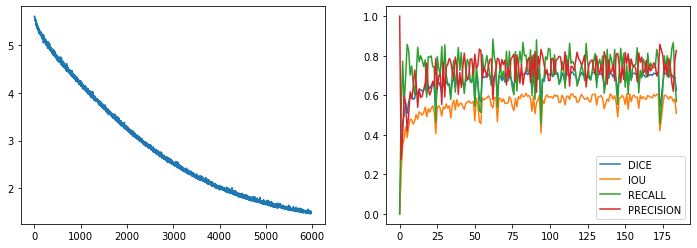

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


		==================== STARTING TRAINING =======================


2023-12-21 00:39:36.352552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | TuckerUNet | 939 K 
1 | loss_func | MARSLoss   | 939 K 
-----------------------------------------
939 K     Trainable params
0         Non-trainable params
939 K     Total params
3.757     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

		======================= MODEL SAVED ==========================


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


		==================== TRAINING ENDED    =======================
		======================= MODEL LOADED =========================
		==================== STARTING TESTING  =======================


Testing: |          | 0/? [00:00<?, ?it/s]


	TEST DICE: mean = 0.0000, std = 0.0000, q2.5% = 0.0000, q97.5% = 0.0000
	TEST IOU: mean = 0.0000, std = 0.0000, q2.5% = 0.0000, q97.5% = 0.0000
	TEST RECALL: mean = 0.0000, std = 0.0000, q2.5% = 0.0000, q97.5% = 0.0000
	TEST PRECISION: mean = 1.0000, std = 0.0000, q2.5% = 1.0000, q97.5% = 1.0000



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_dice_mean       │            0.0            │
│      test_dice_q025       │            0.0            │
│      test_dice_q975       │            0.0            │
│       test_dice_var       │            0.0            │
│       test_iou_mean       │            0.0            │
│       test_iou_q025       │            0.0            │
│       test_iou_q975       │            0.0            │
│       test_iou_var        │            0.0            │
│    test_precision_mean    │            1.0            │
│    test_precision_q025    │            1.0            │
│    test_precision_q975    │            1.0            │
│    test_precision_var     │            0.0            │
│     test_recall_mean      │            0.0            │
│     test_recall_q025      │            0.0            │
│     test_recall_q975      │            0.0            │
│      test_recall_var      │            0.0            │
└───────────────────────────┴───────────────────────────┘

		==================== TESTING ENDED     =======================


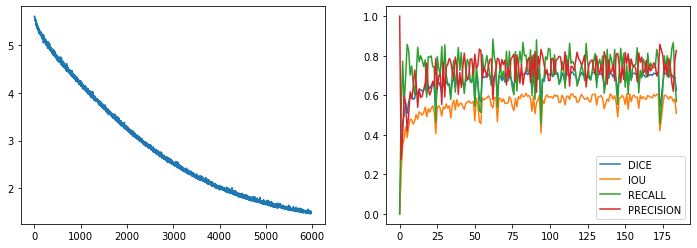

In [248]:
#!g1.1
loss_name = "dice_loss"
experiment_name="cocostuff_tree_Tucker_UNET_32_3_encoder_only"

tucker_model = setup_experiment_mars(
    **get_general_params(
        scheduler_cls=torch.optim.lr_scheduler.CyclicLR,
        scheduler_params={
            "base_lr": 3e-4,
            "max_lr": 1e-3,
            "step_size_up": 76 * ACCUM_GRAD,
            "mode": 'exp_range',
            "cycle_momentum": False,
        },
        patience=100,
        visualize_step=40,
        max_epoch=300,
    ),
    mars='tucker',
    mars_params={"rank":40, "pi":1e-1, "alpha":-1.5, "encoder_only":True},
    loss_func=all_loss_params[loss_name]["func"],
    loss_params=all_loss_params[loss_name]["loss_params"],
    experiment_name=experiment_name,
)

Layer:  Tucker Conv2d: [3, 32, 3, 3] -> [3, 40]-[40, 40, 3, 3]-[40, 32]


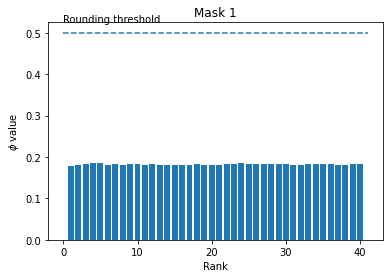

#nz ranks: 0/40


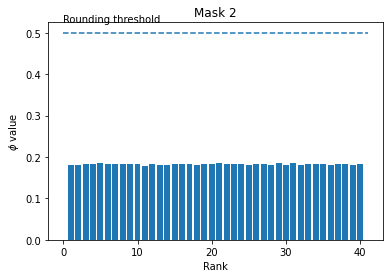

#nz ranks: 0/40

Compression:	inf
Layer:  Tucker Conv2d: [32, 32, 3, 3] -> [32, 40]-[40, 40, 3, 3]-[40, 32]


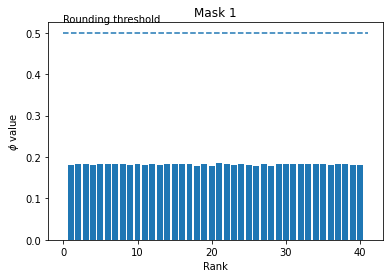

#nz ranks: 0/40


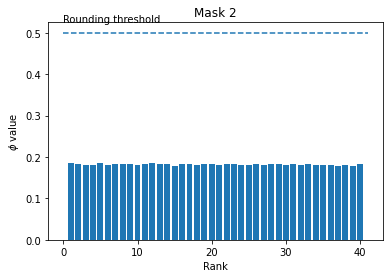

#nz ranks: 0/40

Compression:	inf
Layer:  Tucker Conv2d: [32, 64, 3, 3] -> [32, 40]-[40, 40, 3, 3]-[40, 64]


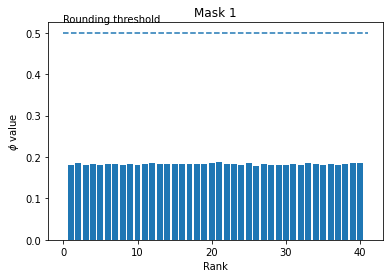

#nz ranks: 0/40


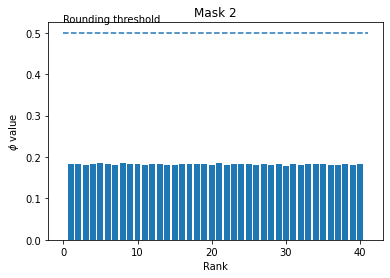

#nz ranks: 0/40

Compression:	inf
Layer:  Tucker Conv2d: [64, 64, 3, 3] -> [64, 40]-[40, 40, 3, 3]-[40, 64]


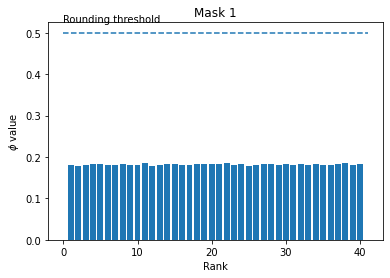

#nz ranks: 0/40


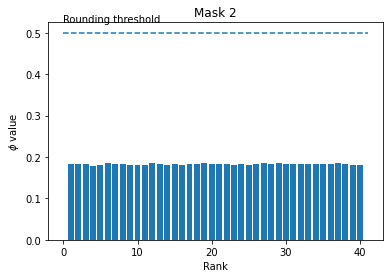

#nz ranks: 0/40

Compression:	inf
Layer:  Tucker Conv2d: [64, 128, 3, 3] -> [64, 40]-[40, 40, 3, 3]-[40, 128]


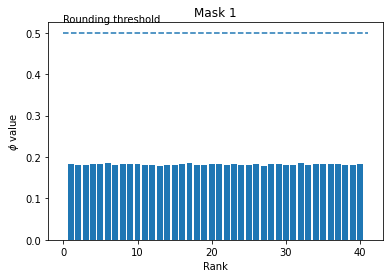

#nz ranks: 0/40


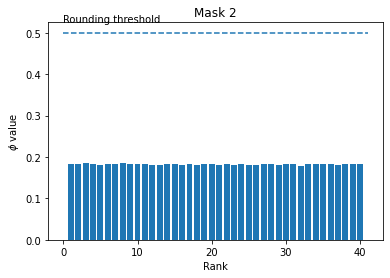

#nz ranks: 0/40

Compression:	inf
Layer:  Tucker Conv2d: [128, 128, 3, 3] -> [128, 40]-[40, 40, 3, 3]-[40, 128]


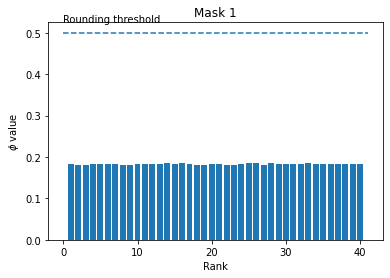

#nz ranks: 0/40


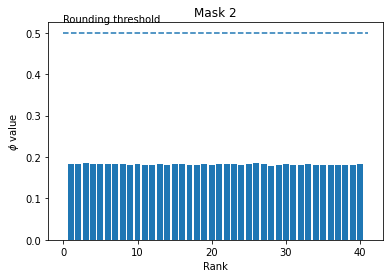

#nz ranks: 0/40

Compression:	inf
Layer:  Tucker Conv2d: [128, 256, 3, 3] -> [128, 40]-[40, 40, 3, 3]-[40, 256]


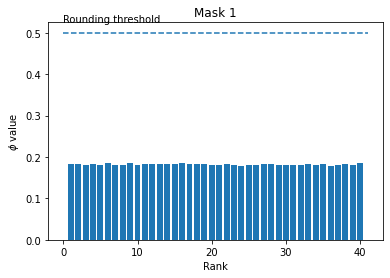

#nz ranks: 0/40


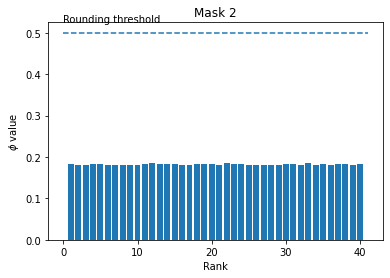

#nz ranks: 0/40

Compression:	inf
Layer:  Tucker Conv2d: [256, 256, 3, 3] -> [256, 40]-[40, 40, 3, 3]-[40, 256]


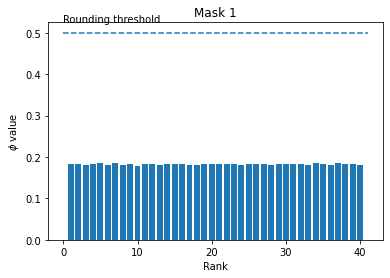

#nz ranks: 0/40


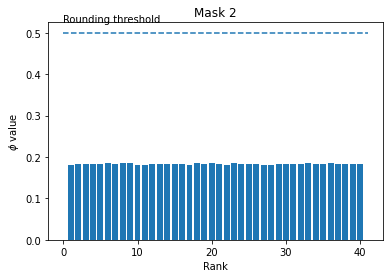

#nz ranks: 0/40

Compression:	inf
Total compression:	2.548


2.547887819047292

In [249]:
#!g1.1
tucker_model.prepare_for_train()
get_comp_info(tucker_model)

### TT U-Net only encoder convolutions Experiment


		 cocostuff_tree_TT_UNET_32_3_encoder_only 
		==================== PARAMETER ESTIMATION ====================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          TTConv2d-1         [-1, 32, 320, 320]               0
              MARS-2         [-1, 32, 320, 320]               0
       BatchNorm2d-3         [-1, 32, 320, 320]              64
              ReLU-4         [-1, 32, 320, 320]               0
          TTConv2d-5         [-1, 32, 320, 320]               0
              MARS-6         [-1, 32, 320, 320]               0
       BatchNorm2d-7         [-1, 32, 320, 320]              64
              ReLU-8         [-1, 32, 320, 320]               0
      TTDoubleConv-9         [-1, 32, 320, 320]               0
        MaxPool2d-10         [-1, 32, 160, 160]               0
         TTConv2d-11         [-1, 64, 160, 160]               0
             MARS-12         [-1, 64, 160, 160]          

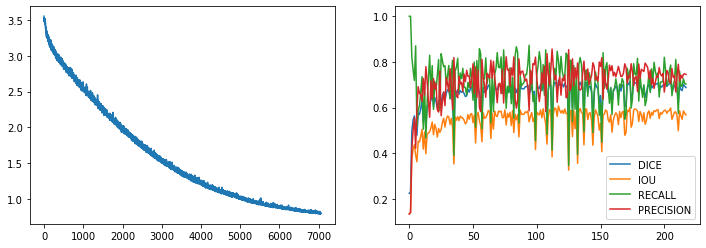

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | model     | TTUNet   | 948 K 
1 | loss_func | MARSLoss | 948 K 
---------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.793     Total estimated model params size (MB)


		==================== STARTING TRAINING =======================


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

		======================= MODEL SAVED ==========================


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


		==================== TRAINING ENDED    =======================
		======================= MODEL LOADED =========================
		==================== STARTING TESTING  =======================


Testing: |          | 0/? [00:00<?, ?it/s]


	TEST DICE: mean = 0.2387, std = 0.0269, q2.5% = 0.0348, q97.5% = 0.6021
	TEST IOU: mean = 0.1463, std = 0.0136, q2.5% = 0.0177, q97.5% = 0.4307
	TEST RECALL: mean = 1.0000, std = 0.0000, q2.5% = 1.0000, q97.5% = 1.0000
	TEST PRECISION: mean = 0.1463, std = 0.0136, q2.5% = 0.0177, q97.5% = 0.4307



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_dice_mean       │    0.23868256328061202    │
│      test_dice_q025       │    0.03478263307395617    │
│      test_dice_q975       │    0.6020513988039787     │
│       test_dice_var       │    0.02688081119283927    │
│       test_iou_mean       │    0.14626235494235718    │
│       test_iou_q025       │   0.017699462890625003    │
│       test_iou_q975       │       0.43066796875       │
│       test_iou_var        │   0.013586469615473678    │
│    test_precision_mean    │    0.14626252776793644    │
│    test_precision_q025    │     0.017699462890625     │
│    test_precision_q975    │       0.43066796875       │
│    test_precision_var     │   0.013586537432984757    │
│     test_recall_mean      │    0.9999977644851319     │
│     test_recall_q025      │            1.0            │
│     test_recall_q975      │            1.0            │
│      test_recall_var      │   2.434580667612388e-10   │
└───────────────────────────┴───────────────────────────┘

		==================== TESTING ENDED     =======================


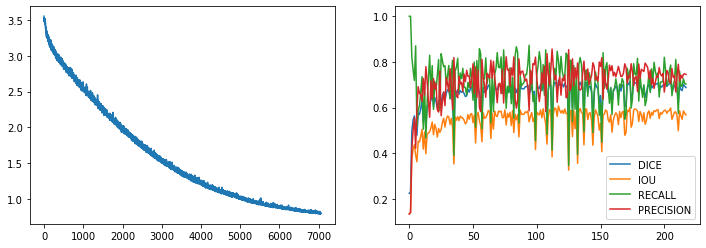

In [250]:
#!g1.1
loss_name = "dice_loss"
experiment_name="cocostuff_tree_TT_UNET_32_3_encoder_only"

tt_model = setup_experiment_mars(
    **get_general_params(
        scheduler_cls=torch.optim.lr_scheduler.CyclicLR,
        scheduler_params={
            "base_lr": 3e-4,
            "max_lr": 1e-3,
            "step_size_up": 76 * ACCUM_GRAD,
            "mode": 'exp_range',
            "cycle_momentum": False,
        },
        patience=100,
        visualize_step=40,
        max_epoch=300,
    ),
    mars='tt',
    mars_params={"d":3, "tt_rank":22, "pi":1e-1, "alpha":-1.5, "encoder_only":True},
    loss_func=all_loss_params[loss_name]["func"],
    loss_params=all_loss_params[loss_name]["loss_params"],
    experiment_name=experiment_name,
)

Layer:  TT Conv2d with a TT-Matrix of size 32 x 27, underlying tensorshape: [2, 4, 4] x [3, 3, 3], TT-ranks: [1, 22, 22, 1] 
 on device 'cpu' with compression rate 0.14


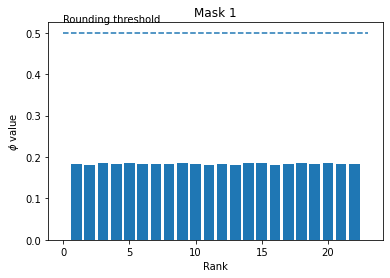

#nz ranks: 0/22


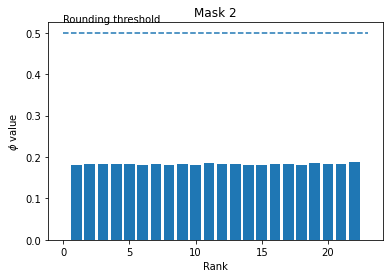

#nz ranks: 0/22

Compression:	inf
Layer:  TT Conv2d with a TT-Matrix of size 32 x 288, underlying tensorshape: [2, 4, 4] x [6, 6, 8], TT-ranks: [1, 22, 22, 1] 
 on device 'cpu' with compression rate 0.73


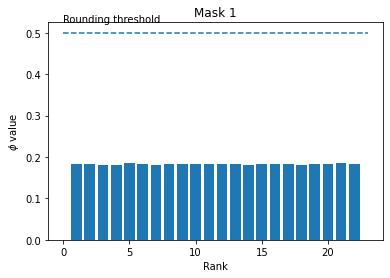

#nz ranks: 0/22


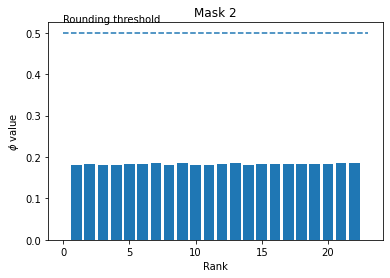

#nz ranks: 0/22

Compression:	inf
Layer:  TT Conv2d with a TT-Matrix of size 64 x 288, underlying tensorshape: [4, 4, 4] x [6, 6, 8], TT-ranks: [1, 22, 22, 1] 
 on device 'cpu' with compression rate 1.43


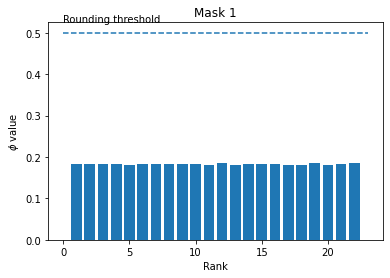

#nz ranks: 0/22


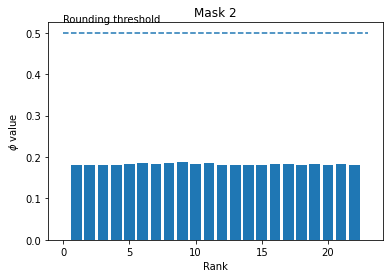

#nz ranks: 0/22

Compression:	inf
Layer:  TT Conv2d with a TT-Matrix of size 64 x 576, underlying tensorshape: [4, 4, 4] x [8, 8, 9], TT-ranks: [1, 22, 22, 1] 
 on device 'cpu' with compression rate 2.17


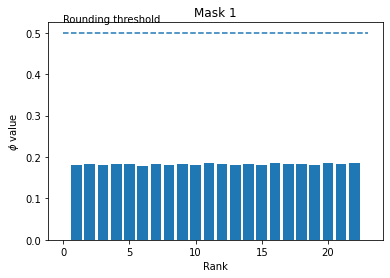

#nz ranks: 0/22


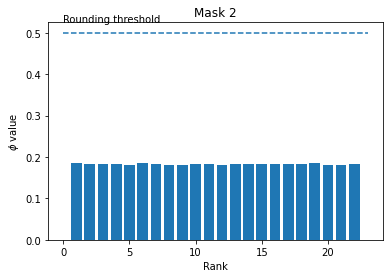

#nz ranks: 0/22

Compression:	inf
Layer:  TT Conv2d with a TT-Matrix of size 128 x 576, underlying tensorshape: [4, 4, 8] x [8, 8, 9], TT-ranks: [1, 22, 22, 1] 
 on device 'cpu' with compression rate 4.15


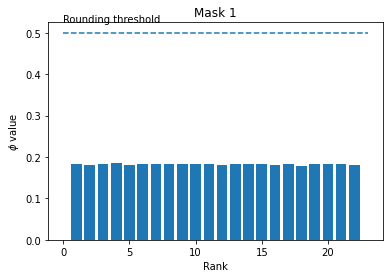

#nz ranks: 0/22


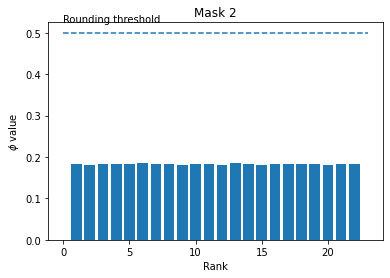

#nz ranks: 0/22

Compression:	inf
Layer:  TT Conv2d with a TT-Matrix of size 128 x 1152, underlying tensorshape: [4, 4, 8] x [8, 12, 12], TT-ranks: [1, 22, 22, 1] 
 on device 'cpu' with compression rate 5.66


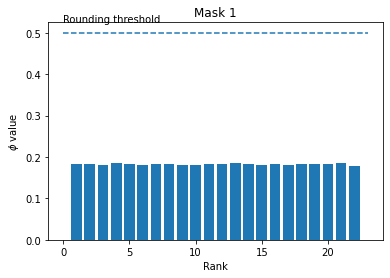

#nz ranks: 0/22


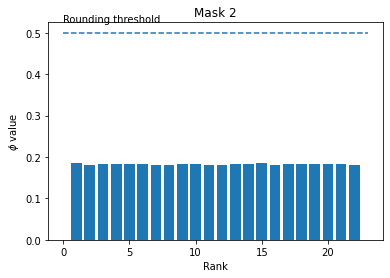

#nz ranks: 0/22

Compression:	inf
Layer:  TT Conv2d with a TT-Matrix of size 256 x 1152, underlying tensorshape: [4, 8, 8] x [8, 12, 12], TT-ranks: [1, 22, 22, 1] 
 on device 'cpu' with compression rate 5.98


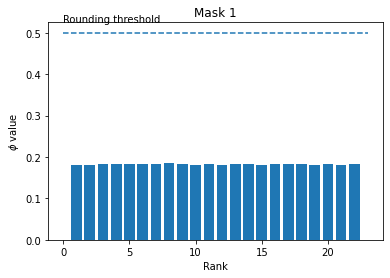

#nz ranks: 0/22


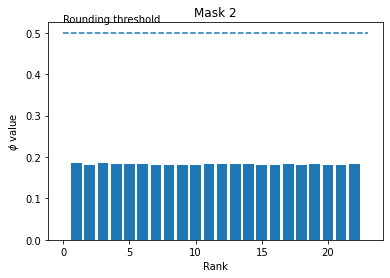

#nz ranks: 0/22

Compression:	inf
Layer:  TT Conv2d with a TT-Matrix of size 256 x 2304, underlying tensorshape: [4, 8, 8] x [12, 12, 16], TT-ranks: [1, 22, 22, 1] 
 on device 'cpu' with compression rate 11.72


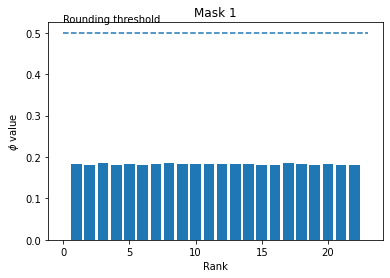

#nz ranks: 0/22


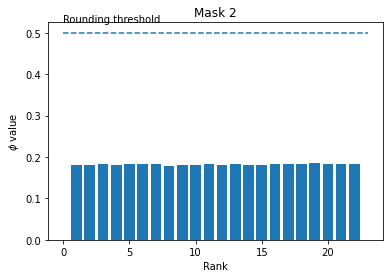

#nz ranks: 0/22

Compression:	inf
Total compression:	2.550


2.549854051493491

In [251]:
#!g1.1
tt_model.prepare_for_train()
get_comp_info(tt_model)